# imports

Will use device: cpu, torch dtype: torch.float32


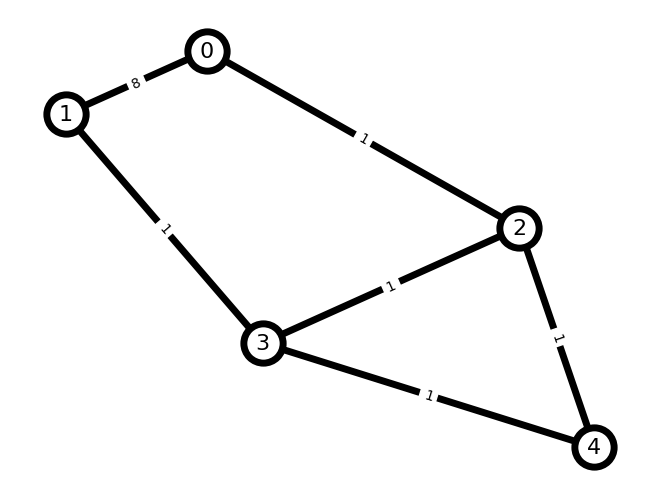

In [3]:
from GraphCreator import *
# import dgl
# import torch
# import random
# import os
# import numpy as np
# import networkx as nx
# import torch.nn as nn
# import torch.nn.functional as F
# import torch as th
# import matplotlib
# from collections import OrderedDict, defaultdict
# from dgl.nn.pytorch import GraphConv
# from itertools import chain, islice, combinations
# from networkx.algorithms.approximation.clique import maximum_independent_set as mis
# from time import time
# from networkx.algorithms.approximation.maxcut import one_exchange
#
# # MacOS can have issues with MKL. For more details, see
# # https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
#
# # fix seed to ensure consistent results
# seed_value = 1
# random.seed(seed_value)        # seed python RNG
# np.random.seed(seed_value)     # seed global NumPy RNG
# torch.manual_seed(seed_value)  # seed torch RNG
#
# # Set GPU/CPU
# TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# TORCH_DTYPE = torch.float32
# print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

In [4]:
class GCN_dev(nn.Module):
    def __init__(self, in_feats, hidden_size, number_classes, dropout, device):
        """
        Initialize a new instance of the core GCN model of provided size.
        Dropout is added in forward step.

        Inputs:
            in_feats: Dimension of the input (embedding) layer
            hidden_size: Hidden layer size
            dropout: Fraction of dropout to add between intermediate layer. Value is cached for later use.
            device: Specifies device (CPU vs GPU) to load variables onto
        """
        super(GCN_dev, self).__init__()

        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, number_classes).to(device)

    def forward(self, g, inputs):
        """
        Run forward propagation step of instantiated model.

        Input:
            self: GCN_dev instance
            g: DGL graph object, i.e. problem definition
            inputs: Input (embedding) layer weights, to be propagated through network
        Output:
            h: Output layer weights
        """

        # input step
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = F.dropout(h, p=self.dropout_frac)

        # output step
        h = self.conv2(g, h)
        h = torch.sigmoid(h)

        return h


class GCN_dev2(nn.Module):
    def __init__(self, in_feats, hidden_size, number_classes, dropout, device):
        """
        Initialize a new instance of the core GCN model of provided size.
        Dropout is added in forward step.

        Inputs:
            in_feats: Dimension of the input (embedding) layer
            hidden_size: Hidden layer size
            dropout: Fraction of dropout to add between intermediate layer. Value is cached for later use.
            device: Specifies device (CPU vs GPU) to load variables onto
        """
        super(GCN_dev2, self).__init__()

        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, number_classes).to(device)

    def forward(self, g, inputs):
        """
        Run forward propagation step of instantiated model.

        Input:
            self: GCN_dev instance
            g: DGL graph object, i.e. problem definition
            inputs: Input (embedding) layer weights, to be propagated through network
        Output:
            h: Output layer weights
        """

        # input step
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = F.dropout(h, p=self.dropout_frac)

        # output step
        h = self.conv2(g, h)
        h = torch.softmax(h)

        return h

# Helper

In [5]:
def qubo_dict_to_torch(nx_G, Q, torch_dtype=None, torch_device=None):
    """
    Output Q matrix as torch tensor for given Q in dictionary format.

    Input:
        Q: QUBO matrix as defaultdict
        nx_G: graph as networkx object (needed for node lables can vary 0,1,... vs 1,2,... vs a,b,...)
    Output:
        Q: QUBO as torch tensor
    """

    # get number of nodes
    n_nodes = len(nx_G.nodes)

    # get QUBO Q as torch tensor
    Q_mat = torch.zeros(n_nodes, n_nodes)
    for (x_coord, y_coord), val in Q.items():
        Q_mat[x_coord][y_coord] = val

    if torch_dtype is not None:
        Q_mat = Q_mat.type(torch_dtype)

    if torch_device is not None:
        Q_mat = Q_mat.to(torch_device)

    return Q_mat
def graph_to_weighted_min_cut_qubo(graph):
    """
    Convert a weighted NetworkX graph into a QUBO matrix for the Min-Cut problem.

    Parameters:
    - graph: A weighted NetworkX graph

    Returns:
    - qubo: The QUBO matrix as a 2D NumPy array
    """
    n = len(graph.nodes)
    #qubo = np.zeros((n, n))
    qubo = defaultdict(int)

    for i in graph.nodes:
        qubo[(i,i)] = sum(weight['weight'] for _, _, weight in graph.edges(i, data=True))

    for i, j, weight in graph.edges(data=True):
        qubo[(i,j)] = -2 * weight['weight']

    for u in graph.nodes:
        print(u)
        for i in graph.nodes:
            if not qubo[(u, i)]:
                qubo[(u, i)] = 0

    return qubo


def gen_q_dict_mis(nx_G, penalty=2):
    """
    Helper function to generate QUBO matrix for MIS as minimization problem.

    Input:
        nx_G: graph as networkx graph object (assumed to be unweigthed)
    Output:
        Q_dic: QUBO as defaultdict
    """

    # Initialize our Q matrix
    Q_dic = defaultdict(int)

    # Update Q matrix for every edge in the graph
    # all off-diagonal terms get penalty
    for (u, v) in nx_G.edges:
        Q_dic[(u, v)] = penalty

    # all diagonal terms get -1
    for u in nx_G.nodes:
        Q_dic[(u, u)] = -1

    return Q_dic

def gen_adj_matrix2(nx_G):
    adj_dict = defaultdict(int)

    for(u,v) in nx_G.edges:
        adj_dict[(u, v)] = nx_G[u][v]['weight'] + (nx_G[u][v]['weight'] - 13)
        print(u,v, nx_G[u][v]['weight'])
    # adj_dict[(0,0)] = 14
    # adj_dict[(4,4)] = 14
    print("----")
    for u in nx_G.nodes:
        print(u)
        for i in nx_G.nodes:
            if not adj_dict[(u, i)]:
                adj_dict[(u, i)] = 0
        adj_dict[(0,0)] = 13
    print(adj_dict)
    return adj_dict



def gen_adj_matrix3(nx_G):
    adj_dict = defaultdict(int)

    for(u,v) in nx_G.edges:
        adj_dict[(u, v)] = nx_G[u][v]['weight'] + (nx_G[u][v]['weight'] - 13)
        adj_dict[(v, u)] = nx_G[u][v]['weight'] + (nx_G[u][v]['weight'] - 13)
        print(u,v, nx_G[u][v]['weight'])
    # adj_dict[(0,0)] = 14
    # adj_dict[(4,4)] = 14
    print("----")
    for u in nx_G.nodes:
        print(u)
        for i in nx_G.nodes:
            if not adj_dict[(u, i)]:
                adj_dict[(u, i)] = 0
        adj_dict[(0,0)] = 13
    print(adj_dict)
    return adj_dict


def gen_adj_matrix(nx_G):
    adj_dict = defaultdict(int)

    for(u,v) in nx_G.edges:
        adj_dict[(u, v)] = nx_G[u][v]['weight']
        print(u,v, nx_G[u][v]['weight'])
    # adj_dict[(0,0)] = 14
    # adj_dict[(4,4)] = 14
    print("----")
    for u in nx_G.nodes:
        print(u)
        for i in nx_G.nodes:
            if not adj_dict[(u, i)]:
                adj_dict[(u, i)] = 0
        #adj_dict[(0,0)] = 23
    print(adj_dict)
    return adj_dict


# create graph

{(0, 1): Text(-0.5497473792061034, 0.7312259948670438, '8'),
 (0, 2): Text(0.09480676122706669, 0.46259936537177826, '1'),
 (1, 3): Text(-0.47072680948410256, 0.037400634628221574, '1'),
 (2, 3): Text(0.17382733094906755, -0.23122599486704393, '1'),
 (2, 4): Text(0.6451983149004905, -0.47850351783897904, '1'),
 (3, 4): Text(0.2804691125626482, -0.7527224770280649, '1')}

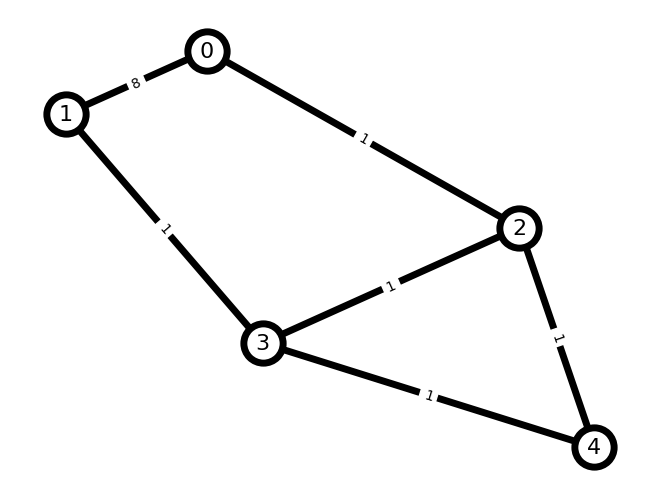

In [6]:
# test_graph = nx.Graph()
# test_graph.add_edges_from([(0,1, {"weight": 8}),(0,2, {"weight": 1}),(1,3, {"weight": 1}),(2,3, {"weight": 1}),(2,4, {"weight": 1}),(3,4, {"weight": 1})])
# test_graph.order()

#est_graph = nx.OrderedGraph([(0,1),(0,2),(1,3),(2,3),(2,4),(3,4)])
test_graph = CreateDummyFunction()
pos = nx.spring_layout(test_graph,seed=1)

# Visualize graph
options = {
    "font_size": 16,
    "node_size": 800,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw(test_graph, pos, with_labels=True, **options)

labels = nx.get_edge_attributes(test_graph,'weight')
nx.draw_networkx_edge_labels(test_graph,pos,edge_labels=labels)

# convert to QUBO

In [7]:
# graph_dgl = dgl.from_networkx(nx_graph=test_graph)
# graph_dgl = graph_dgl.to(TORCH_DEVICE)
#
# # Construct Q matrix for graph
# q_torch = qubo_dict_to_torch(test_graph, graph_to_weighted_min_cut_qubo(test_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)


graph_dgl = dgl.from_networkx(nx_graph=test_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(test_graph, gen_adj_matrix3(test_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

0 1 8
0 2 1
1 3 1
2 3 1
2 4 1
3 4 1
----
0
1
2
3
4
defaultdict(<class 'int'>, {(0, 1): 3, (1, 0): 3, (0, 2): -11, (2, 0): -11, (1, 3): -11, (3, 1): -11, (2, 3): -11, (3, 2): -11, (2, 4): -11, (4, 2): -11, (3, 4): -11, (4, 3): -11, (0, 0): 13, (0, 3): 0, (0, 4): 0, (1, 1): 0, (1, 2): 0, (1, 4): 0, (2, 1): 0, (2, 2): 0, (3, 0): 0, (3, 3): 0, (4, 0): 0, (4, 1): 0, (4, 4): 0})


# set hyper parameter

In [8]:
# Graph hypers
n = 5
d = 3
p = None
graph_type = 'reg'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 100    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 5

# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

# loss function

In [10]:
# helper function for custom loss according to Q matrix
def loss_func(probs, Q_mat):
    """
    Function to compute cost value for given probability of spin [prob(+1)] and predefined Q matrix.

    Input:
        probs: Probability of each node belonging to each class, as a vector
        Q_mat: QUBO as torch tensor
    """

    probs_ = torch.unsqueeze(probs, 1)
    # print(probs_)
    # print("___")
    # print(Q_mat)
    # print("probsitem")
    # print((probs.detach() >= 0.5) * 1)

    # minimize cost = x.T * Q * x
    cost = (probs_.T @ Q_mat @ probs_).squeeze()

    print("cost item")
    print((probs_.T @ Q_mat @ probs_))
    print(cost)

    print("end one loss")

    return cost



def min_cut_loss(output, adj_matrix):
    # Calculate the probability of nodes being in different sets
    prob_diff = output.unsqueeze(1) - output.unsqueeze(0)
    prob_diff = torch.abs(prob_diff)

    # Calculate the weighted edges between different sets
    edge_weights_diff = prob_diff * adj_matrix

    # Sum the weights for minimization
    loss = edge_weights_diff.sum()
    return loss

def min_cut_loss2(output, adj_matrix, terminal_a, terminal_b, penalty=5):
    # Calculate the probability of nodes being in different sets
    prob_diff = output.unsqueeze(1) - output.unsqueeze(0)
    prob_diff = torch.abs(prob_diff)

    # Calculate the weighted edges between different sets
    edge_weights_diff = prob_diff * adj_matrix

    # Sum the weights for minimization
    loss = edge_weights_diff.sum()

    # Add penalty if terminals are in the same subset
    terminal_loss = torch.abs(output[terminal_a] - output[terminal_b])
    loss += penalty * (1 - terminal_loss)

    return loss

def min_cut_loss3(output, adj_matrix, terminal_a, terminal_b, penalty=1000):
    loss = 0
    i = 0
    # for u in nx_G.nodes:
    #     for i in nx_G.nodes:
    #         loss += torch.where((output[i] > 0.5 and output[u] < 0.5) or (output[i] < 0.5 and output[u] > 0.5), adj_matrix[(u,i)], 0)

    i = 0
    j = 0
    for i in range(len(adj_matrix)-1):
        for j in range(len(adj_matrix)-1):
            loss += torch.where((output[i] > 0.5 and output[j] < 0.5) or (output[i] < 0.5 and output[j] > 0.5), adj_matrix[i][j], 0)

    # Add penalty if terminals are in the same subset
    terminal_loss = torch.abs(output[terminal_a] - output[terminal_b])
    loss += penalty * (1 - terminal_loss)

    return loss

def loss_function_halo2(output, graph, K = 2):
    # output: GCNN model output, which includes assignments of vertices to cores and halos
    # graph: data structure representing the graph, which includes vertex and edge information
    # K: number of partitions

    # Initialize components of the Hamiltonian
    H_A = 0
    H_B = 0
    H_C = 0

    # Compute H_A term
    for v in graph.vertices:
        sum_c_vk = sum(output.core_assignments[v][k] for k in range(K))
        H_A += (sum_c_vk - 1) ** 2

    # Compute H_B term
    for v in graph.vertices:
        for i in range(K):
            for u in graph.neighbors(v):
                if u != v:
                    h_vi = output.halo_assignments[v][i]
                    c_vi = output.core_assignments[v][i]
                    z_uv_i = output.auxiliary_variables[(u,v)][i]
                    H_B += (h_vi - c_vi - z_uv_i) ** 2

    # Compute H_C term
    for i in range(K):
        sum_h_vi = sum(output.halo_assignments[v][i] for v in graph.vertices)
        H_C += sum_h_vi ** 2

    # Combine the terms to get the overall Hamiltonian (loss)
    H = H_A + H_B + H_C

    return H
def loss_function_halo(output, graph, K = 2):
    # output.core_assignments: Tensor of shape [num_vertices, K]
    # output.halo_assignments: Tensor of shape [num_vertices, K]
    # output.auxiliary_variables: Dictionary with keys as edges (u, v) and values as tensors of shape [K]
    # graph: 2x2 Tensor representing the adjacency matrix of the graph
    # K: number of partitions

    # Initialize components of the Hamiltonian
    H_A = torch.tensor(0.0)
    H_B = torch.tensor(0.0)
    H_C = torch.tensor(0.0)

    # Compute H_A term
    for v in range(graph.size(0)):
        # sum_c_vk = torch.sum(output.core_assignments[v])
        sum_c_vk = torch.sum(output['core_assignments'][v])
        H_A += (sum_c_vk - 1) ** 2

    # Compute H_B term
    for v in range(graph.size(0)):
        for i in range(K):
            h_vi = output.halo_assignments[v, i]
            c_vi = output.core_assignments[v, i]
            for u in range(graph.size(1)):
                if graph[v, u] == 1 and u != v:  # Check if u is a neighbor of v
                    z_uv_i = output.auxiliary_variables[(u, v)][i]
                    H_B += (h_vi - c_vi - z_uv_i) ** 2

    # Compute H_C term
    for i in range(K):
        sum_h_vi = torch.sum(output.halo_assignments[:, i])
        H_C += sum_h_vi ** 2

    # Combine the terms to get the overall Hamiltonian (loss)
    H = H_A + H_B + H_C

    return H
#

# training function

In [15]:

def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCN_dev(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer


def get_gnn2(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCN_dev2(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

def run_gnn_training(q_torch, dgl_graph, net, embed, optimizer, number_epochs, tol, patience, prob_threshold, loss_func):
    """
    Wrapper function to run and monitor GNN training. Includes early stopping.
    """
    # Assign variable for user reference
    inputs = embed.weight

    #print("input", inputs.data.fill_(1))

    prev_loss = 100.  # initial loss value (arbitrary)
    count = 0       # track number times early stopping is triggered

    # initialize optimal solution
    best_bitstring = torch.zeros((dgl_graph.number_of_nodes(),)).type(q_torch.dtype).to(q_torch.device)
    # best_loss = loss_func(best_bitstring.float(), q_torch)
    best_loss = loss_func(best_bitstring.float(), q_torch, 0, 4)
    #best_loss = loss_func(best_bitstring.float(), q_torch)
    t_gnn_start = time()

    # Training logic
    for epoch in range(number_epochs):

        # get logits/activations
        torch.autograd.set_detect_anomaly(True)
        probs = net(dgl_graph, inputs)[:, 0]  # collapse extra dimension output from model
        #probs = torch.unsqueeze(probs, 1)

        # print("this is probs" , probs)
        # print("this is probs[0]" , probs[0])
        #probs[0] = th.tensor(0.25, requires_grad = True)
        #probs[-1] = th.tensor(0.75, requires_grad = True)

        #probs.squeeze()
        # print("this is after probs[0]" , probs[0])
        #print("this is after probs" , probs)
        # probs.retain_grad()
        #print("this is after retains probs" , probs)
        #print("printing probs", probs[0])
        # build cost value with QUBO cost function
        #loss = loss_func(probs, q_torch)


        #loss = min_cut_loss(probs, q_torch)
        loss = loss_func(probs, q_torch, 0, 4)
        #loss = loss_function_halo(probs, q_torch)

        #loss.requires_grad
        #print("comes here", loss)
        loss_ = loss.detach().item()
        #print("comes here2", loss_)
        # Apply projection
        bitstring = (probs.detach() >= prob_threshold) * 1
        if loss < best_loss:
            best_loss = loss
            best_bitstring = bitstring

        if epoch % 1000 == 0:
            print("probs:", (probs.detach() >= prob_threshold) * 1)
            print(f'Epoch: {epoch}, Loss: {loss_}')
            print("this is after probs" , probs)

        # early stopping check
        # If loss increases or change in loss is too small, trigger
        if (abs(loss_ - prev_loss) <= tol) | ((loss_ - prev_loss) > 0):
            count += 1
        else:
            count = 0

        if count >= patience:
            print(f'Stopping early on epoch {epoch} (patience: {patience})')
            break
        torch.autograd.set_detect_anomaly(True)
        # update loss tracking
        prev_loss = loss_
        #print("backwardf loss", loss)
        # run optimization with backpropagation
        optimizer.zero_grad()  # clear gradient for step
        #print("is leaf", loss.is_leaf)
        #print(probs.)
        loss.backward()        # calculate gradient through compute graph
        #print(list(net.parameters())[0].grad)
        optimizer.step()       # take step, update weights
        #net.conv2.apply(weightConstraint())


    t_gnn = time() - t_gnn_start
    print(f'GNN training (n={dgl_graph.number_of_nodes()}) took {round(t_gnn, 3)}')
    print(f'GNN final continuous loss: {loss_}')
    print(f'GNN best continuous loss: {best_loss}')

    final_bitstring = (probs.detach() >= prob_threshold) * 1

    return net, epoch, final_bitstring, best_bitstring


from time import time

def run_gnn_training2(q_torch, dgl_graph, net, embed, optimizer, number_epochs, tol, patience, prob_threshold, adjacency_matrix, K):
    """
    Wrapper function to run and monitor GNN training. Includes early stopping.
    Inputs:
        - q_torch: torch tensor representation of the graph (e.g., adjacency matrix)
        - dgl_graph: DGL graph object
        - net: the GCN_dev network instance
        - embed: embedding layer
        - optimizer: optimizer for training
        - number_epochs: number of training epochs
        - tol: tolerance for early stopping
        - patience: patience for early stopping
        - prob_threshold: threshold for determining core/halo assignments
        - adjacency_matrix: adjacency matrix of the graph for loss calculation
        - K: number of partitions
    Returns:
        - net: trained network
        - epoch: last epoch
        - final_bitstring: final assignments of vertices
        - best_bitstring: best assignments of vertices observed
    """
    inputs = embed.weight
    prev_loss = float('inf')  # initial high loss value
    count = 0  # track number times early stopping is triggered
    best_loss = float('inf')
    best_bitstring = None

    t_gnn_start = time()

    for epoch in range(number_epochs):
        net.train()  # Set network to training mode
        optimizer.zero_grad()  # clear gradient for step

        # Forward pass to get logits/activations
        probs = net(dgl_graph, inputs)


        # The loss is the cut size, which we aim to minimize
        loss =   loss_function_halo(probs, q_torch)


    # Early stopping check
        loss_val = loss.item()
        # if loss_val < best_loss:
        #     best_loss = loss_val
        #     best_bitstring = assignments.clone().detach()
        #
        # if abs(prev_loss - loss_val) <= tol or (loss_val - prev_loss) > 0:
        #     count += 1
        # else:
        #     count = 0
        #
        # if count >= patience:
        #     print(f'Stopping early on epoch {epoch} (patience: {patience})')
        #     break

        prev_loss = loss_val

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}, Loss: {loss_val}')

    t_gnn = time() - t_gnn_start
    print(f'GNN training (n={dgl_graph.number_of_nodes()}) took {round(t_gnn, 3)}')
    print(f'GNN final loss: {loss_val}')
    print(f'GNN best loss: {best_loss}')

    #final_bitstring = assignments.clone().detach()

    return net, epoch, final_bitstring, best_bitstring

In [16]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 2,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

In [17]:
print('Running GNN...')
gnn_start = time()
#net.conv2.apply(weightConstraint())
_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, 100000,
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])
print(final_bitstring)
gnn_time = time() - gnn_start

Running GNN...


TypeError: run_gnn_training() missing 1 required positional argument: 'loss_func'

In [77]:
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)


print('Running GNN...')
gnn_start = time()
#net.conv2.apply(weightConstraint())
_, epoch, final_bitstring, best_bitstring = run_gnn_training2(
    q_torch, graph_dgl, net, embed, optimizer, 10000,
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], gen_adj_matrix3(test_graph), 2)
print(final_bitstring)
gnn_time = time() - gnn_start

Running GNN...
0 1 8
0 2 1
1 3 1
2 3 1
2 4 1
3 4 1
----
0
1
2
3
4
defaultdict(<class 'int'>, {(0, 1): 3, (1, 0): 3, (0, 2): -11, (2, 0): -11, (1, 3): -11, (3, 1): -11, (2, 3): -11, (3, 2): -11, (2, 4): -11, (4, 2): -11, (3, 4): -11, (4, 3): -11, (0, 0): 13, (0, 3): 0, (0, 4): 0, (1, 1): 0, (1, 2): 0, (1, 4): 0, (2, 1): 0, (2, 2): 0, (3, 0): 0, (3, 3): 0, (4, 0): 0, (4, 1): 0, (4, 4): 0})
Epoch: 0, Loss: 0.0


KeyboardInterrupt: 

In [18]:
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)


print('Running GNN...')
gnn_start = time()
#net.conv2.apply(weightConstraint())
_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, 10000,
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], min_cut_loss3)
print(final_bitstring)
gnn_time = time() - gnn_start

Running GNN...
probs: tensor([1, 1, 1, 1, 1])
Epoch: 0, Loss: 998.370361328125
this is after probs tensor([0.5189, 0.5158, 0.5178, 0.5203, 0.5205], grad_fn=<SelectBackward0>)
probs: tensor([1, 1, 1, 1, 1])
Epoch: 1000, Loss: 986.5348510742188
this is after probs tensor([0.5032, 0.5096, 0.5109, 0.5057, 0.5167], grad_fn=<SelectBackward0>)
probs: tensor([0, 1, 1, 0, 1])
Epoch: 2000, Loss: 899.4561767578125
this is after probs tensor([0.4834, 0.5193, 0.5160, 0.4867, 0.5239], grad_fn=<SelectBackward0>)
probs: tensor([0, 1, 1, 0, 1])
Epoch: 3000, Loss: 853.5753173828125
this is after probs tensor([0.4598, 0.5505, 0.5397, 0.4655, 0.5462], grad_fn=<SelectBackward0>)
probs: tensor([0, 1, 1, 0, 1])
Epoch: 4000, Loss: 787.3140258789062
this is after probs tensor([0.4383, 0.6157, 0.6014, 0.4561, 0.5910], grad_fn=<SelectBackward0>)
probs: tensor([0, 1, 1, 0, 1])
Epoch: 5000, Loss: 707.232666015625
this is after probs tensor([0.4259, 0.7095, 0.6943, 0.4618, 0.6587], grad_fn=<SelectBackward0>)
probs:

In [8]:
def calculate_hamiltonian(adj_matrix, partition_vector, A, B, C):
    # Number of vertices
    num_vertices = adj_matrix.shape[0]

    # Ensure partition_vector is a row vector
    partition_vector = partition_vector.view(1, -1)

    # Partition A is where partition_vector is 0, and B is where it is 1
    core_a = (partition_vector == 0).float()  # Core of partition A
    core_b = (partition_vector == 1).float()  # Core of partition B

    # There are only two partitions, so halo of A is core of B and vice versa
    halo_a = core_b  # Halo of partition A is the core of B
    halo_b = core_a  # Halo of partition B is the core of A

    # Calculate H_A, which penalizes multiple partition assignments for a single vertex
    H_A = torch.sum((core_a + core_b - 1) ** 2)

    # Calculate H_B, which involves the edges between vertices and the auxiliary z variable
    # Here, z can be considered as the edges between vertices of different partitions
    # z = core_a @ core_b.T  # Edges between partitions A and B
    # #adj_a = adj_matrix * core_a.T @ core_a  # Edges within partition A
    # adj_a = (adj_matrix @ core_a.T) @ core_a  # Edges within partition A
    # #adj_b = adj_matrix * core_b.T @ core_b  # Edges within partition B
    # adj_b = (adj_matrix @ core_b.T) @ core_b  # Edges within partition B
    # H_B = torch.sum((adj_matrix - (adj_a + adj_b) - z) ** 2)
    # H_B = torch.zeros(1, dtype=torch.float32)
    #
    # # Iterate over each vertex and calculate the discrepancy for each of its edges
    # for v in range(num_vertices):
    #     neighbors = adj_matrix[v] > 0  # A boolean mask for the neighbors of vertex v
    #     # Calculate the discrepancy for vertex v
    #     discrepancy = torch.sum((halo_a[0, v] * core_b[0, neighbors]) +
    #                             (halo_b[0, v] * core_a[0, neighbors]) -
    #                             adj_matrix[v, neighbors])
    #     # Add the squared discrepancy to H_B
    #     H_B += discrepancy ** 2

    expected_connections = torch.matmul(core_a.T, core_b) + torch.matmul(core_b.T, core_a)

    # The discrepancy matrix is the difference between the actual adjacencies and the expected connections
    discrepancy_matrix = adj_matrix - expected_connections
    H_B = torch.sum(discrepancy_matrix ** 2)
    # Calculate H_C, sum of halo indicators squared (halos are the cores of the opposite partition)
    # H_C = torch.sum(halo_a) ** 2 + torch.sum(halo_b) ** 2
    H_C = 0
    #H_C = torch.sum(core_b[0, adj_matrix @ core_a.T > 0]) ** 2 + torch.sum(core_a[0, adj_matrix @ core_b.T > 0]) ** 2


    # Total Hamiltonian
    H = A * H_A + B * H_B + C * H_C

    return H


In [9]:
import networkx as nx
import dgl
import torch

# Define your test graph using NetworkX
test_graph = nx.Graph()
test_graph.add_edges_from([
    (0, 1, {"weight": 8}),
    (0, 2, {"weight": 1}),
    (1, 3, {"weight": 1}),
    (2, 3, {"weight": 1}),
    (2, 4, {"weight": 1}),
    (3, 4, {"weight": 1})
])

# Create a DGL graph from the NetworkX graph without specifying edge attributes
dgl_graph = dgl.from_networkx(test_graph)

# Manually add edge weights to the DGL graph
# Extract edge indices and weights from the NetworkX graph
edges = test_graph.edges(data=True)
src, dst, weights = zip(*[(u, v, data['weight']) for u, v, data in edges])

# Add edge weights to the DGL graph
src_ids = torch.tensor(src, dtype=torch.long)
dst_ids = torch.tensor(dst, dtype=torch.long)
edge_weights = torch.tensor(weights, dtype=torch.float32)

# Since the graph is undirected, add edges in both directions
dgl_graph.add_edges(src_ids, dst_ids, {'weight': edge_weights})
dgl_graph.add_edges(dst_ids, src_ids, {'weight': edge_weights})

# Now get the adjacency matrix in PyTorch format (ensure it's on the CPU for this example)
adjacency_matrix = dgl_graph.adjacency_matrix().to_dense().to(torch.float32)

# The partition vector for your vertices
partition_vector = torch.tensor([0, 1, 1, 0, 1], dtype=torch.float32)

# Coefficients for the terms in the Hamiltonian
A = B = C = 1.0

adjacency_matrix[0][1] = torch.tensor(8, dtype=torch.float32)
adjacency_matrix[1][0] = torch.tensor(8, dtype=torch.float32)
# Calculate the Hamiltonian H

Items = [torch.tensor([0, 1, 1, 0, 1], dtype=torch.float32), torch.tensor([0, 0, 1, 1, 1], dtype=torch.float32), torch.tensor([0, 0, 0, 0, 1], dtype=torch.float32),
         torch.tensor([0, 0, 0, 1, 1], dtype=torch.float32), torch.tensor([0, 1, 1, 1, 1], dtype=torch.float32)]

for i in Items:
    H = calculate_hamiltonian(adjacency_matrix, i, A, B, C)
    print("Hamiltonian H:", H.item())

H = calculate_hamiltonian(adjacency_matrix, partition_vector, A, B, C)
print("Hamiltonian H:", H.item())


Hamiltonian H: 102.0
Hamiltonian H: 142.0
Hamiltonian H: 138.0
Hamiltonian H: 138.0
Hamiltonian H: 110.0
Hamiltonian H: 102.0
